Часть 2: Поиск и фильтрация среди результатов зарплатных опросов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

try:
  import google.colab
  from google.colab import files
  IN_COLAB = True
  path_prefix = 'https://raw.githubusercontent.com/a11ejandro/dou_careers/master/result_csv/'
except:
  IN_COLAB = False
  path_prefix = 'result_csv/'



source_df = pd.read_csv(path_prefix + 'concatenated_source.csv',
                        parse_dates=['timestamp'],
                        dtype={'loc': str, 'currency': str})


Возможные значения в результатах опросов.

In [2]:
replaced_nan = lambda arr: ['N/A' if pd.isnull(x) else x for x in arr]

def unique_sort(series):
    unique = set(replaced_nan(series))
    return sorted(unique)

def unique_sort_multiple(series):
    replaced = replaced_nan(series)
    expanded = list(map(lambda x: x.split(','), replaced))
    unique = set(np.concatenate(expanded))
    return sorted(unique)

ENGLISH_LEVELS = ['элементарный', 'ниже среднего', 'средний', 'выше среднего', 'продвинутый']
EDUCATION_LEVELS = ['Среднее', 'Техникум / Колледж', 'Еще студент', 'Незаконченное высшее', 'Высшее', 'Два высших', 'Кандидат']
POSITIONS = unique_sort(source_df.position)
SPECIALITIES = unique_sort(source_df.speciality)
PROGRAMMING_LANGUAGES = unique_sort(source_df.programming_language)
CITIES = unique_sort(source_df.city)
COMPANY_SIZES = unique_sort(source_df.company_size)
COMPANY_TYPES = unique_sort(source_df.company_type)
GENDERS = unique_sort(source_df.gender)
UNIVERSITIES = unique_sort(source_df.university)
SUBJECT_AREAS = unique_sort(source_df.subject_area)
SUBJECT_AREAS = unique_sort_multiple(source_df.subject_area)

Определения полей для фильтров.

In [3]:
def position_na(values):
    new_values = values.copy()
    
    if 'N/A' in new_values:
        new_values.remove('N/A')
        
    new_values.insert(0, 'N/A')
    return new_values

style = {'description_width': '200px'}
layout = widgets.Layout(width='50%')

university = widgets.Dropdown(
    options=position_na(UNIVERSITIES),
    description='Университет',
    style=style,
    layout=layout,
    disabled=False,
)

education = widgets.Dropdown(
    options=position_na(EDUCATION_LEVELS),
    description='Уровень образования',
    style=style,
    layout=layout,
    disabled=False,
)

programming_language = widgets.Dropdown(
    options = position_na(PROGRAMMING_LANGUAGES),
    description='Язык программирования',
    style=style,
    layout=layout,
    disabled=False
)

position = widgets.Dropdown(
    options=position_na(POSITIONS),
    description='Должность',
    style=style,
    layout=layout,
    disabled=False,
)

speciality = widgets.Dropdown(
    options=position_na(SPECIALITIES),
    description='Специализация',
    style=style,
    layout=layout,
    disabled=False,
)

gender = widgets.Dropdown(
    options=position_na(GENDERS),
    description='Пол',
    style=style,
    layout=layout,
    disabled=False,
)

city = widgets.Dropdown(
    options=position_na(CITIES),
    description='Город',
    style=style,
    layout=layout,
    disabled=False,
)

company_type = widgets.Dropdown(
    options=position_na(COMPANY_TYPES),
    description='Тип компании',
    style=style,
    layout=layout,
    disabled=False,
)

company_size = widgets.Dropdown(
    options=position_na(COMPANY_SIZES),
    description='Размер компании',
    style=style,
    layout=layout,
    disabled=False,
)

subject_area = widgets.Dropdown(
    options=position_na(SUBJECT_AREAS),
    description='Предметная область',
    style=style,
    layout=layout,
    disabled=False,
)

english_level = widgets.Dropdown(
    options=position_na(ENGLISH_LEVELS),
    description='Уровень Английского',
    style=style,
    layout=layout,
    disabled=False,
)

salary = widgets.FloatText(
    value=float('NaN'),
    description='Размер вознаграждения',
    style=style,
    layout=layout,
    disabled=False
)
                          
age = widgets.FloatText(
    value=float('NaN'),
    description='Возраст',
    style=style,
    layout=layout,
    disabled=False
)

total_experience = widgets.FloatText(
    value=float('NaN'),
    description='Общий опыт работы',
    layout=layout,
    style=style,
    disabled=False
)

current_experience = widgets.FloatText(
    value=float('NaN'),
    description='Опыт работы на текущем месте',
    style=style,
    layout=layout,
    disabled=False
)

actual_date = widgets.DatePicker(
    description='Дата, на которую информация была актуальной',
    style=style,
    layout=layout,
    disabled=False
)

lookup_future = widgets.RadioButtons(
    options=[True, False],
    description='Искать в поздних результатах',
    style=style,
    layout=layout,
    disabled=False
)


submit = widgets.Button(description="Обработать")

inputs = {
  'university': university,
  'education': education,
  'programming_language': programming_language,
  'position': position,
  'speciality': speciality,
  'gender': gender,
  'city': city,
  'company_type': company_type,
  'company_size': company_size,
  'english_level': english_level,
  'salary': salary,
  'subject_area': subject_area,
  'age': age,
  'exp': total_experience,
  'current_job_exp': current_experience,
  'timestamp': actual_date,
  'lookup_future': lookup_future,
  'submit': submit,
}



Методы для фильтрации данных.

In [29]:
STRICT_MATCHES = ['university', 'position', 'programming_language', 'speciality', 'gender', 'city', 'company_type', 'company_size']
YEAR_MATCHES = ['age', 'exp', 'current_job_exp']

def strict_match(df, column, value):
    if value == 'N/A':
        return True
    return df[column] == value

def date_match(df, date, lookup_future=False):
    if pd.isnull(date):
        return True

    if lookup_future:
        search_window_start = date
        search_window_end = date + pd.Timedelta(182, 'D')
    else:
        search_window_start = date - pd.Timedelta(182, 'D')
        search_window_end = date
        
    search_window_start = pd.to_datetime(search_window_start).tz_localize('UTC')
    search_window_end = pd.to_datetime(search_window_end).tz_localize('UTC')
    
    return (df.timestamp > search_window_start) & (df.timestamp < search_window_end)

def education_level_match(df, education):
    if education == 'N/A':
        return True
    return df.education_level == EDUCATION_LEVELS.index(education)

def english_level_match(df, english_level):
    if english_level == 'N/A':
        return True
    return df.english_level == ENGLISH_LEVELS.index(english_level)

def years_match(df, column, value):
    if value == 'N/A' or pd.isnull(value):
        return True
    return (value - df[column]) <= 1

def salary_match(df, value):
    return (True if pd.isnull(value) else df['salary'] == value)

def apply_matchers(df):
    checks_results = list(map(lambda x: years_match(df, x, inputs[x].value), YEAR_MATCHES))
    checks_results += list(map(lambda x: strict_match(df, x, inputs[x].value), STRICT_MATCHES))
    checks_results.append(salary_match(df, inputs['salary'].value))
    checks_results.append(english_level_match(df, inputs['english_level'].value))
    checks_results.append(education_level_match(df, inputs['education'].value))
    checks_results.append(date_match(df, inputs['timestamp'].value, lookup_future = inputs['lookup_future'].value))

    result = checks_results[0]

    for new_check in checks_results[1:]:
        result = result & new_check
    
    return result

Поиск похожих анкет в других опросах.

In [30]:
JOINED_SUFFIX='_joined'
SIMILAR_SUFFIX='_similar'
RELATION_SUFFIX='_relation'


EXTRACT_COLUMNS=['N', 'position', 'programming_language', 'speciality',
       'salary_delta_1y', 'city', 'company_size', 'company_type', 'gender',
       'university', 'subject_area', 'exp', 'current_job_exp', 'salary',
       'currency', 'cls', 'timestamp', 'english_level', 'education_level',
       'age']

def get_graph_dfs(df):
    primary_results = df.drop_duplicates(['N', 'timestamp'])[EXTRACT_COLUMNS]
    related_columns = list(map(lambda x: x + SIMILAR_SUFFIX, EXTRACT_COLUMNS))
    related = []

    for index, primary_row in primary_results.iterrows():
        related_rows = df[
            (df['N' + SIMILAR_SUFFIX] == primary_row['N']) &
            (df['timestamp' + SIMILAR_SUFFIX] == primary_row['timestamp'])
        ]
        
        related_rows = related_rows[related_columns].drop_duplicates()
        related_rows.columns = EXTRACT_COLUMNS
        related.append(related_rows)
        
    return primary_results, pd.concat(related)

output = widgets.Output()

join_df = pd.read_csv(path_prefix + 'join.csv', parse_dates=['timestamp', 'timestamp' + JOINED_SUFFIX])

def join_related_entries(df):
    join_straight = df.merge(
        join_df, 
        how='inner',
        on=['N', 'timestamp'],
    )

    join_reverse = df.merge(
        join_df, 
        how='inner',
        left_on=['N', 'timestamp'],
        right_on = ['N' + JOINED_SUFFIX, 'timestamp' + JOINED_SUFFIX],
        suffixes=['', RELATION_SUFFIX]
    )

    joined_straight = join_straight.merge(
        source_df,
        how='inner',
        left_on=['N' + JOINED_SUFFIX, 'timestamp' + JOINED_SUFFIX],
        right_on=['N', 'timestamp'],
        suffixes=['', SIMILAR_SUFFIX]
    )

    joined_reverse = join_reverse.merge(
        source_df,
        how='inner',
        left_on=['N' + RELATION_SUFFIX, 'timestamp' + RELATION_SUFFIX],
        right_on=['N', 'timestamp'],
        suffixes=['', SIMILAR_SUFFIX]
    )

    return pd.concat([joined_straight, joined_reverse])

found, related = None, None

def handle_submit(b):
    global found, related

    print('Обработка формы.')
    
    filtered_df = source_df[apply_matchers(source_df)]
    full_records = join_related_entries(filtered_df)

    found, related = get_graph_dfs(full_records)
    print('Данные отфильтрованы.')
    


submit.on_click(handle_submit)

[display(input, output) for input in inputs.values()]
print()


Dropdown(description='Университет', layout=Layout(width='50%'), options=('N/A', 'ВНТУ', 'ВНУ им. Даля', 'ГУТ',…

Output()

Dropdown(description='Уровень образования', layout=Layout(width='50%'), options=('N/A', 'Среднее', 'Техникум /…

Output()

Dropdown(description='Язык программирования', index=21, layout=Layout(width='50%'), options=('N/A', '1С', 'ABA…

Output()

Dropdown(description='Должность', layout=Layout(width='50%'), options=('N/A', 'BI Engineer', 'Business Analyst…

Output()

Dropdown(description='Специализация', layout=Layout(width='50%'), options=('N/A', 'Automation QA', 'General QA…

Output()

Dropdown(description='Пол', layout=Layout(width='50%'), options=('N/A', 'женский', 'мужской'), style=Descripti…

Output()

Dropdown(description='Город', index=8, layout=Layout(width='50%'), options=('N/A', 'Винница', 'Днепр', 'Днепр.…

Output()

Dropdown(description='Тип компании', layout=Layout(width='50%'), options=('N/A', 'Аутсорсинговая', 'Аутстаффин…

Output()

Dropdown(description='Размер компании', layout=Layout(width='50%'), options=('N/A', 'до 10 человек', 'до 1000 …

Output()

Dropdown(description='Уровень Английского', layout=Layout(width='50%'), options=('N/A', 'элементарный', 'ниже …

Output()

FloatText(value=nan, description='Размер вознаграждения', layout=Layout(width='50%'), style=DescriptionStyle(d…

Output()

Dropdown(description='Предметная область', layout=Layout(width='50%'), options=('N/A', 'Android', 'Desktop App…

Output()

FloatText(value=nan, description='Возраст', layout=Layout(width='50%'), style=DescriptionStyle(description_wid…

Output()

FloatText(value=nan, description='Общий опыт работы', layout=Layout(width='50%'), style=DescriptionStyle(descr…

Output()

FloatText(value=nan, description='Опыт работы на текущем месте', layout=Layout(width='50%'), style=Description…

Output()

DatePicker(value=datetime.date(2019, 4, 5), description='Дата, на которую информация была актуальной', layout=…

Output()

RadioButtons(description='Искать в поздних результатах', layout=Layout(width='50%'), options=(True, False), st…

Output()

Button(description='Обработать', style=ButtonStyle())

Output()


Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.
Обработка формы.
Данные отфильтрованы.


Характеристики выборки

In [31]:
all_df = pd.concat([related, found])
print(all_df.salary.describe([.1, .25, .5, .75, .9]))

count      131.000000
mean      2330.656489
std       1673.274357
min        400.000000
10%        600.000000
25%       1000.000000
50%       1900.000000
75%       3350.000000
90%       4600.000000
max      10000.000000
Name: salary, dtype: float64


Графики изменения з/п в зависимости от образования, английского, возраста, опыта, размера и типа компании.

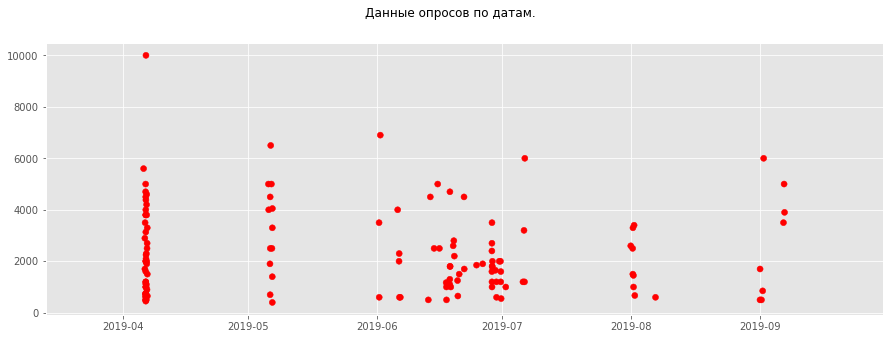

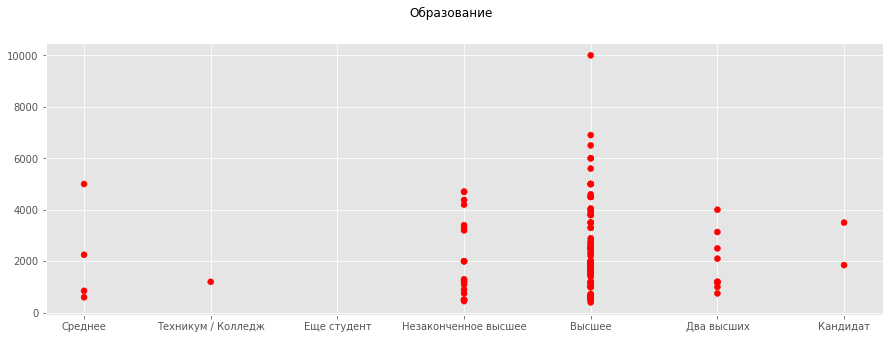

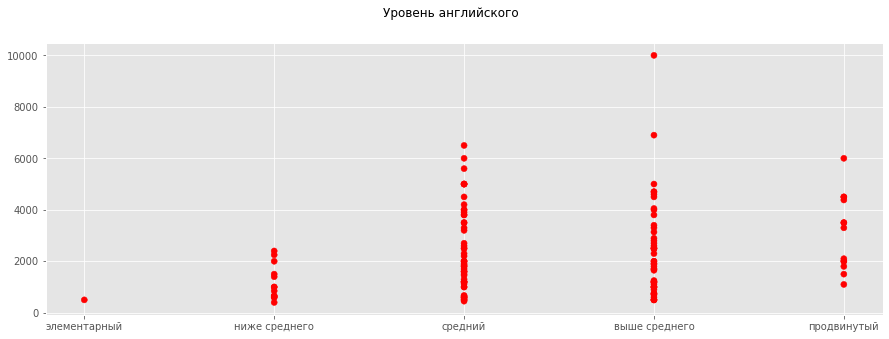

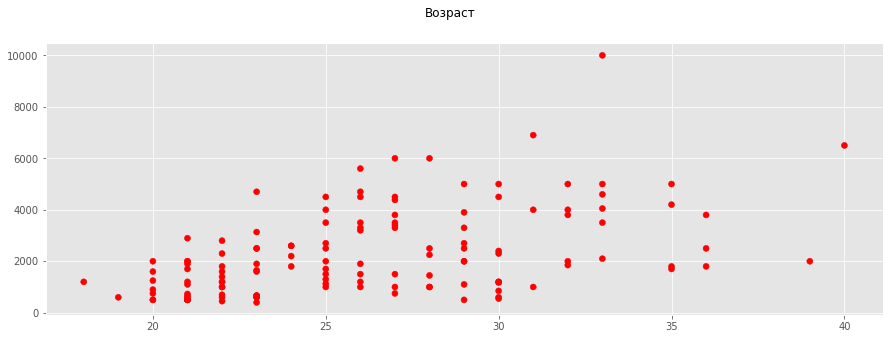

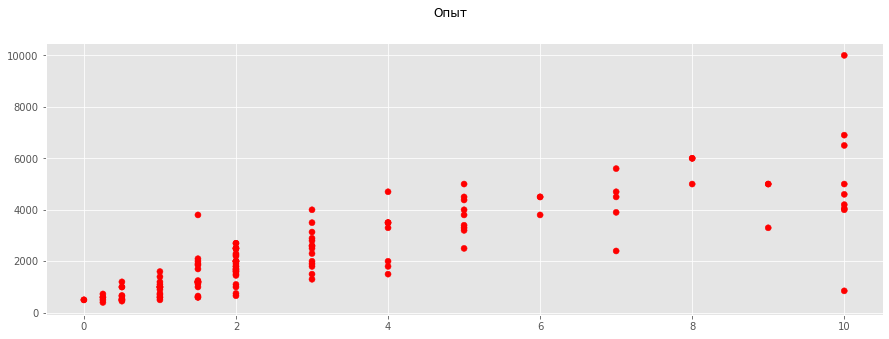

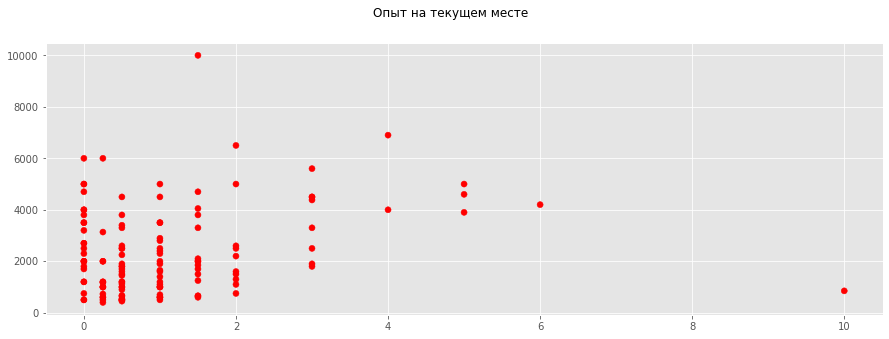

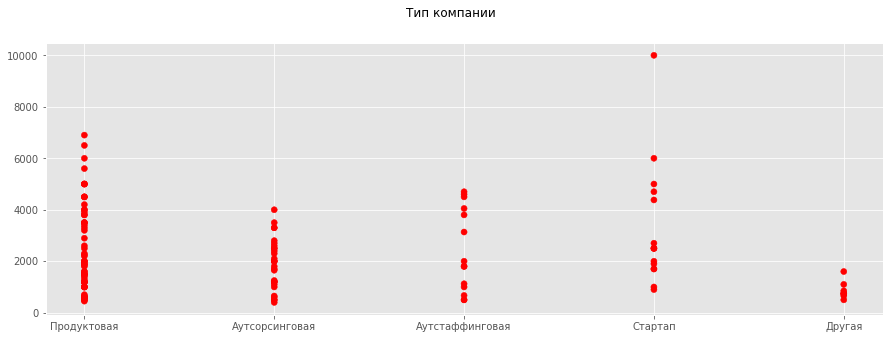

In [32]:
y = related['salary']
colors = ['#0000ff' for _ in y]
y = y.append(found['salary'])
colors += ['#ff0000' for _, __ in found.iterrows()]

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

timestamp = plt.figure()
timestamp.suptitle('Данные опросов по датам.')
x = all_df.timestamp
plt.scatter(x, y, c=colors)

education = plt.figure()
education.suptitle('Образование')
x = all_df.education_level
plt.scatter(x, y, c=colors)
plt.xticks(range(len(EDUCATION_LEVELS)), EDUCATION_LEVELS)

english = plt.figure()
english.suptitle('Уровень английского')
x = all_df.english_level
plt.scatter(x, y, c=colors)
plt.xticks(range(len(ENGLISH_LEVELS)), ENGLISH_LEVELS)

age = plt.figure()
age.suptitle('Возраст')
x = all_df.age
plt.scatter(x, y, c=colors)

exp = plt.figure()
exp.suptitle('Опыт')
x = all_df.exp
plt.scatter(x, y, c=colors)

exp = plt.figure()
exp.suptitle('Опыт на текущем месте')
x = all_df.current_job_exp
plt.scatter(x, y, c=colors)

exp = plt.figure()
exp.suptitle('Тип компании')
x = all_df.company_type
plt.scatter(x, y, c=colors)

exp = plt.figure()
exp.suptitle('Размер компании')
x = all_df.company_size
plt.scatter(x, y, c=colors)

plt.close()